In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrnd
import jax.scipy.stats as stats

from kernels import atransp_elliptical_slice
from centering import projectiongradient_to_numpyro, AutoStdNormal

import numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import effective_sample_size as ess, print_summary
from numpyro.infer import SVI, Trace_ELBO, MCMC, NUTS
from numpyro.infer.reparam import NeuTraReparam
from numpyro.infer.autoguide import AutoIAFNormal, AutoDiagonalNormal

import optax
from jax.example_libraries import stax
from jax.experimental.host_callback import id_print

import matplotlib.pyplot as plt
import arviz as az

from exec import run_atess, run_neutra, run_nuts

2022-05-26 13:10:38.857732: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [2]:
from jax.config import config
config.update("jax_debug_nans", True)
config.update("jax_enable_x64", True)

In [3]:
def inference_loop(rng, init_state, kernel, n_iter, param):
    keys = jrnd.split(rng, n_iter)
    def step(state, key):
        state, info = kernel(key, state, param)
        return state, (state, info)
    _, (states, info) = jax.lax.scan(step, init_state, keys)
    return states, info

In [4]:
def plot_contour(logprob, samples=None):
    a, b, c, d = -7.5, 7.5, -5, 12.5
    x1 = jnp.linspace(a, b, 1000)
    x2 = jnp.linspace(c, d, 1000)
    y = jax.vmap(
        jax.vmap(lambda x1, x2: jnp.exp(banana_fn({"x1": x1, "x2": x2})), (0, None)),
        (None, 0),
    )(x1, x2)
    plt.figure(figsize=(10, 7.5))
    CS = plt.contour(x1, x2, y, levels=10, colors="k")
    plt.clabel(CS, inline=1, fontsize=10)
    if samples is not None:
        plt.plot(samples["x1"].T, samples["x2"].T, ".")

In [5]:
def compare_plot_contour(logprob, atess, other):
    a, b, c, d = -7.5, 7.5, -5, 12.5
    a, b, c, d = -10, 10, -5, 20
    a, b, c, d = -3., 5, -200, 200
    x1 = jnp.linspace(a, b, 1000)
    x2 = jnp.linspace(c, d, 1000)
    y = jax.vmap(
        jax.vmap(lambda x1, x2: jnp.exp(logprob({"x1": x1, "x2": x2})), (0, None)),
        (None, 0),
    )(x1, x2)
    fig, ax = plt.subplots(1, 2, figsize=(17, 6), sharex=True, sharey=True)
    CS0 = ax[0].contour(x1, x2, y, levels=10, colors="k")
    plt.clabel(CS0, inline=1, fontsize=10)
    CS1 = ax[1].contour(x1, x2, y, levels=10, colors="k")
    plt.clabel(CS1, inline=1, fontsize=10)
    ax[0].set_title("ATESS samples")
    ax[0].plot(atess["x1"].T, atess["x2"].T, ".")
    ax[1].set_title("Other samples")
    ax[1].plot(other["x1"].T, other["x2"].T, ".")

# Neal's funnel

In [6]:
def funnel(x1, x2):
    """Neal's funnel density"""
    return stats.norm.logpdf(x1, 0.0, 1.) + stats.norm.logpdf(
        x2, 0., jnp.exp(2. * x1)
    )
funnel_fn = lambda x: funnel(**x)

def funnel_model():
    x1 = numpyro.sample('x1', dist.Normal(0., 1.))
    numpyro.sample('x2', dist.Normal(0., jnp.exp(2. * x1)))

In [7]:
n = 2

optim = optax.adam(1e-3)
# optim = optax.chain(
#     optax.clip(10.),
#     optax.adam(1e-3)
# )
non_lin = stax.Tanh
# non_lin = stax.Elu
n_hidden = [n] * 1
n_atoms = 10
n_flow = 2

n_epochs = 5
batch_size = 1000
n_warm = n_epochs * batch_size

vi_iter = 1000
pre_iter = n_epochs * vi_iter
n_warm = vi_iter #too much warm up not good for nuts, it semms

n_iter = 1000
n_chain = 4

In [8]:
def funnel_reparam():
    x1 = numpyro.sample('x1', dist.Normal(0., 1.))
    with numpyro.handlers.reparam(config={'x2': numpyro.infer.reparam.LocScaleReparam(None)}):
        numpyro.sample('x2', dist.Normal(0., jnp.exp(2. * x1)))
# def funnel_reparam():
#     x1 = numpyro.sample('x1', dist.Normal(0., 1.))
#     lamda = numpyro.param('x2_centered', 1.)
#     numpyro.sample('x2', dist.Normal(0., jnp.exp(2. * x1) ** lamda))
guide_reparam = AutoDiagonalNormal(funnel_reparam)
# guide_reparam = AutoStdNormal(funnel_reparam)
# def guide_reparam():
# #     means = numpyro.param('auto_loc', jnp.zeros(2))
#     means = jnp.zeros(2)
#     x1 = numpyro.sample('x1', dist.Normal(means[0], 1.))
#     numpyro.sample('x2_decentered', dist.Normal(means[1], 1.))
svi = SVI(funnel_reparam, guide_reparam, optax.adam(1e-2), Trace_ELBO(n_atoms))
krep = jrnd.PRNGKey(1)
params = svi.run(krep, num_steps=vi_iter, progress_bar=False).params
print(params)
funnel_model = numpyro.handlers.substitute(funnel_reparam, params)#{'x2_centered': 0.})# params)
funnel_fn2 = lambda x: numpyro.infer.util.log_density(
    numpyro.handlers.seed(funnel_model, krep), (), {}, x
)[0]

{'auto_loc': DeviceArray([0.05431604, 0.01176159], dtype=float32), 'auto_scale': DeviceArray([0.9765121, 1.0403738], dtype=float32), 'x2_centered': DeviceArray(0.04868842, dtype=float32)}


In [10]:
ksam, ki1, ki2 = jrnd.split(jrnd.PRNGKey(0), 3)
# init_xs = {'x1': jrnd.normal(ki1, shape=(n_chain,)), 'x2': jrnd.normal(ki2, shape=(n_chain,))}
init_xs = {'x1': jrnd.normal(ki1, shape=(n_chain,)), 'x2_decentered': jrnd.normal(ki2, shape=(n_chain,))}
samples = run_atess(
    ksam, funnel_fn2, init_xs,
    optim, n, n_flow, n_hidden, non_lin,
    n_atoms, vi_iter, n_epochs, batch_size,
    n_iter, n_chain,
)


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             x1     -0.08      1.03     -0.06     -1.84      1.53   2301.74      1.00
  x2_decentered      0.00      1.03      0.00     -1.64      1.73   3175.46      1.00



In [9]:
atess, warm_fn = atransp_elliptical_slice(funnel_fn2, optim, n, n_flow, n_hidden, non_lin)
ksam, ki1, ki2 = jrnd.split(jrnd.PRNGKey(0), 3)

def one_chain(ksam, init_x):
    kinit, kwarm, ksam = jrnd.split(ksam, 3)
    state, param, err = atess.init(kinit, init_x, n_atoms, vi_iter)
    (state, param), error = warm_fn(kwarm, state, param, n_epochs, batch_size, vi_iter)
    states, info = inference_loop(ksam, state, atess.step, n_iter, param)
    return states.position, info.subiter.mean(), (err, param, error)

# init_xs = {'x1': jrnd.normal(ki1, shape=(n_chain,)), 'x2': jrnd.normal(ki2, shape=(n_chain,))}
init_xs = {'x1': jrnd.normal(ki1, shape=(n_chain,)), 'x2_decentered': jrnd.normal(ki2, shape=(n_chain,))}
ksam = jrnd.split(ksam, n_chain)
samples, subiter, diagnose = jax.vmap(one_chain)(ksam, init_xs)
print_summary(samples)

/home/cabezasg/.local/lib/python3.8/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             x1     -0.08      1.03     -0.06     -1.84      1.53   2301.74      1.00
  x2_decentered      0.00      1.03      0.00     -1.64      1.73   3175.46      1.00



In [10]:
atess, warm_fn = atransp_elliptical_slice(funnel_fn2, optim, n, n_flow, n_hidden, non_lin)
ksam, ki1, ki2 = jrnd.split(jrnd.PRNGKey(0), 3)

def one_chain(ksam, init_x):
    kinit, kwarm, ksam = jrnd.split(ksam, 3)
    state, param, err = atess.init(kinit, init_x, n_atoms, vi_iter)
    (state, param), error = warm_fn(kwarm, state, param, n_epochs, batch_size, vi_iter)
    states, info = inference_loop(ksam, state, atess.step, n_iter, param)
    return states.position, info.subiter.mean(), (err, param, error)

# init_xs = {'x1': jrnd.normal(ki1, shape=(n_chain,)), 'x2': jrnd.normal(ki2, shape=(n_chain,))}
init_xs = {'x1': jrnd.normal(ki1, shape=(n_chain,)), 'x2_decentered': jrnd.normal(ki2, shape=(n_chain,))}
ksam = jrnd.split(ksam, n_chain)
samples, subiter, diagnose = jax.vmap(one_chain)(ksam, init_xs)
print_summary(samples)


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             x1     -0.05      1.01     -0.04     -1.65      1.67   3209.08      1.00
  x2_decentered     -0.00      1.07     -0.01     -1.59      1.90   2497.12      1.00



In [11]:
samples['x2'] = jax.vmap(lambda x1, x2: jnp.exp(2. * x1) ** (1-params['x2_centered']) * x2)(samples['x1'], samples['x2_decentered'])

In [12]:
print_summary(samples)


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             x1     -0.05      1.01     -0.04     -1.65      1.67   3209.08      1.00
  x2_decentered     -0.00      1.07     -0.01     -1.59      1.90   2497.12      1.00
             x2      0.59     24.13     -0.00    -10.18      8.52   2087.35      1.00



In [8]:
guide = AutoIAFNormal(funnel_model, num_flows=n_flow, hidden_dims=n_hidden, nonlinearity=non_lin)
svi = SVI(funnel_model, guide, optim, loss=Trace_ELBO(n_atoms))

ksam, ki1, ki2 = jrnd.split(jrnd.PRNGKey(0), 3)
params = svi.run(ksam, num_steps=pre_iter, progress_bar=False).params
print(params)
neutra = NeuTraReparam(guide, params)
reparam_model = neutra.reparam(funnel_model)

mcmc = MCMC(NUTS(reparam_model), num_warmup=n_warm, num_samples=n_iter, num_chains=n_chain, progress_bar=False)
init_xs = {'x1': jrnd.normal(ki1, shape=(n_chain,)), 'x2': jrnd.normal(ki2, shape=(n_chain,))}

ksam, kmcmc = jrnd.split(ksam)
mcmc.run(kmcmc, init_params=init_xs)
mcmc.print_summary(exclude_deterministic=False)

{'auto_arn__0$params': [(DeviceArray([[0.8686471 , 0.73475575],
             [0.15826097, 0.743056  ]], dtype=float32), DeviceArray([0.06822257, 0.06270041], dtype=float32)), (), (DeviceArray([[-0.08314557,  0.08223918, -0.28410754,  0.01147667],
             [ 1.2492968 ,  0.41640264, -0.18868497, -0.47675258]],            dtype=float32), DeviceArray([ 0.08224238,  0.08504933, -0.08142584, -0.08342664], dtype=float32))], 'auto_arn__1$params': [(DeviceArray([[-0.4840864 ,  0.09596331],
             [-0.24476165,  0.78253233]], dtype=float32), DeviceArray([-0.80416656,  0.10509928], dtype=float32)), (), (DeviceArray([[-0.1850227 , -0.5320296 ,  0.60801053, -0.32953414],
             [ 0.3125233 ,  0.0564832 , -0.03756913, -0.37412772]],            dtype=float32), DeviceArray([ 0.0807086 ,  0.08661935, -0.08161916, -0.08780154], dtype=float32))]}


/tmp/ipykernel_34551/300835031.py:10: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(NUTS(reparam_model), num_warmup=n_warm, num_samples=n_iter, num_chains=n_chain, progress_bar=False)



                           mean       std    median      5.0%     95.0%     n_eff     r_hat
auto_shared_latent[0]      1.37     29.40     -0.32    -15.94     13.33    201.34      1.02
auto_shared_latent[1]      0.14      1.13      0.22     -1.50      1.51      7.41      1.28
                   x1      0.25      0.97      0.32     -1.24      1.57      7.40      1.27
                   x2      1.94     29.97     -0.02    -15.93     14.52    198.75      1.02

Number of divergences: 1157


In [11]:
mcmc = MCMC(NUTS(funnel_model), num_warmup=n_warm, num_samples=n_iter, num_chains=n_chain, progress_bar=False)
init_xs = {'x1': jrnd.normal(ki1, shape=(n_chain,)), 'x2': jrnd.normal(ki2, shape=(n_chain,))}

ksam, kmcmc = jrnd.split(ksam)
mcmc.run(kmcmc, init_params=init_xs)
mcmc.print_summary(exclude_deterministic=False)

/tmp/ipykernel_76074/3689975882.py:1: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(NUTS(funnel_model), num_warmup=n_warm, num_samples=n_iter, num_chains=n_chain, progress_bar=False)



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             x1     -0.00      1.02     -0.00     -1.72      1.72   2650.90      1.00
             x2     -0.58     37.78     -0.00     -9.14      8.49   2369.70      1.00
  x2_decentered     -0.01      1.00     -0.01     -1.72      1.55   2483.43      1.00

Number of divergences: 0


In [14]:
mcmc = MCMC(NUTS(funnel_model), num_warmup=n_warm, num_samples=n_iter, num_chains=n_chain, progress_bar=False)
init_xs = {'x1': jrnd.normal(ki1, shape=(n_chain,)), 'x2': jrnd.normal(ki2, shape=(n_chain,))}

ksam, kmcmc = jrnd.split(ksam)
mcmc.run(kmcmc, init_params=init_xs)
mcmc.print_summary(exclude_deterministic=False)

/tmp/ipykernel_152839/3689975882.py:1: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(NUTS(funnel_model), num_warmup=n_warm, num_samples=n_iter, num_chains=n_chain, progress_bar=False)



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             x1      0.02      1.01      0.00     -1.73      1.61   3245.80      1.00
             x2      0.04     24.30     -0.00     -9.83      9.13   2543.83      1.00
  x2_decentered     -0.02      1.00     -0.01     -1.57      1.70   2569.73      1.00

Number of divergences: 0


DeviceArray([1.2980001, 1.2780001, 1.3470001, 1.2770001], dtype=float32)

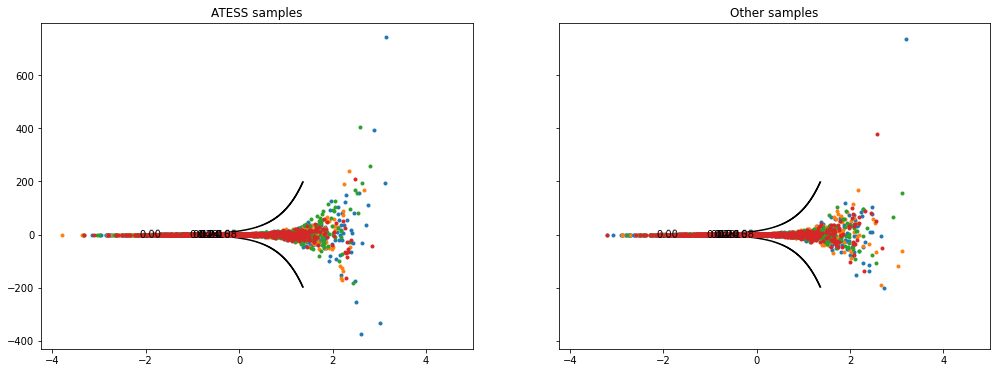

In [75]:
compare_plot_contour(funnel_fn, samples, mcmc.get_samples(group_by_chain=True))
subiter

array([<AxesSubplot:title={'center':'x1'}, xlabel='Total number of draws', ylabel='ESS'>,
       <AxesSubplot:title={'center':'x2_decentered'}, xlabel='Total number of draws', ylabel='ESS'>,
       <AxesSubplot:title={'center':'x2'}, xlabel='Total number of draws', ylabel='ESS'>],
      dtype=object)

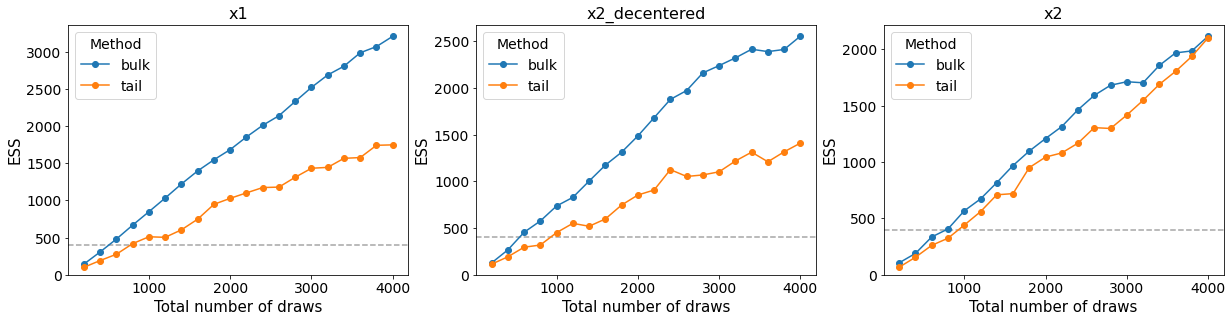

In [76]:
inf_samples = az.from_dict(samples)
inf_nuts = az.from_numpyro(mcmc)
az.plot_ess(inf_samples, kind="evolution")

array([[<AxesSubplot:title={'center':'auto_shared_latent\n0'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot:title={'center':'auto_shared_latent\n1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot:title={'center':'x1'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<AxesSubplot:title={'center':'x2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot:title={'center':'x2_decentered'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot:>]], dtype=object)

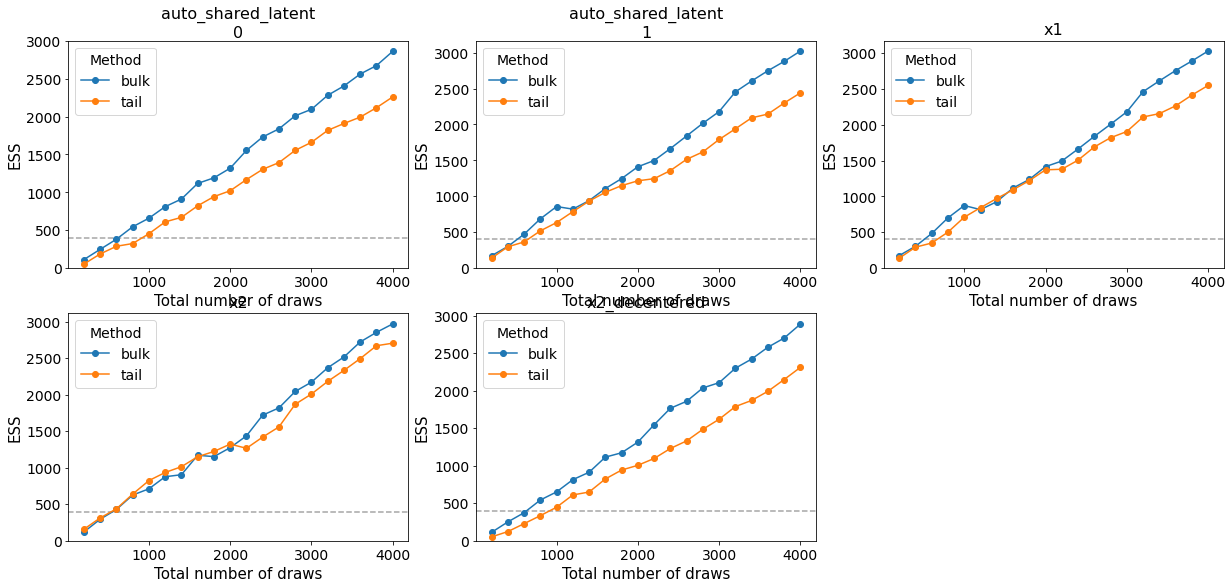

In [77]:
az.plot_ess(inf_nuts, kind="evolution")

array([[<AxesSubplot:title={'center':'x1'}>,
        <AxesSubplot:title={'center':'x1'}>],
       [<AxesSubplot:title={'center':'x2'}>,
        <AxesSubplot:title={'center':'x2'}>]], dtype=object)

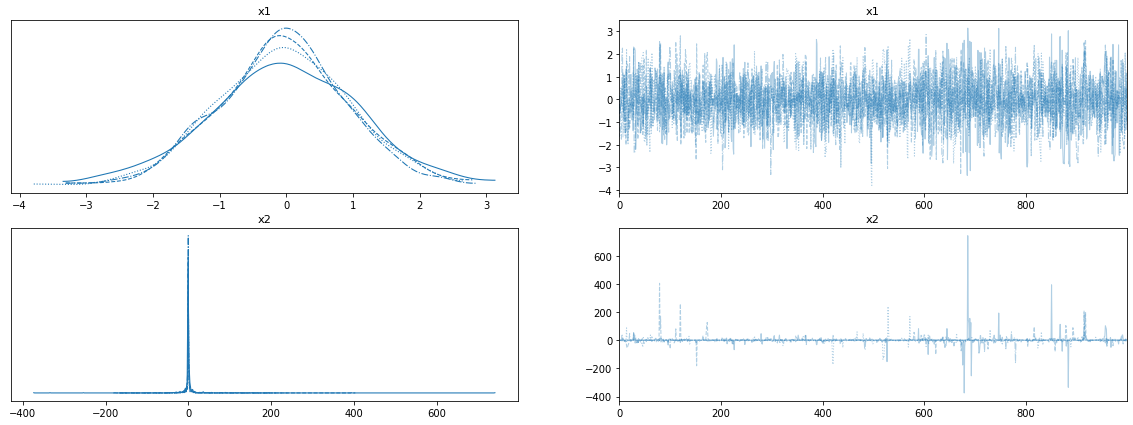

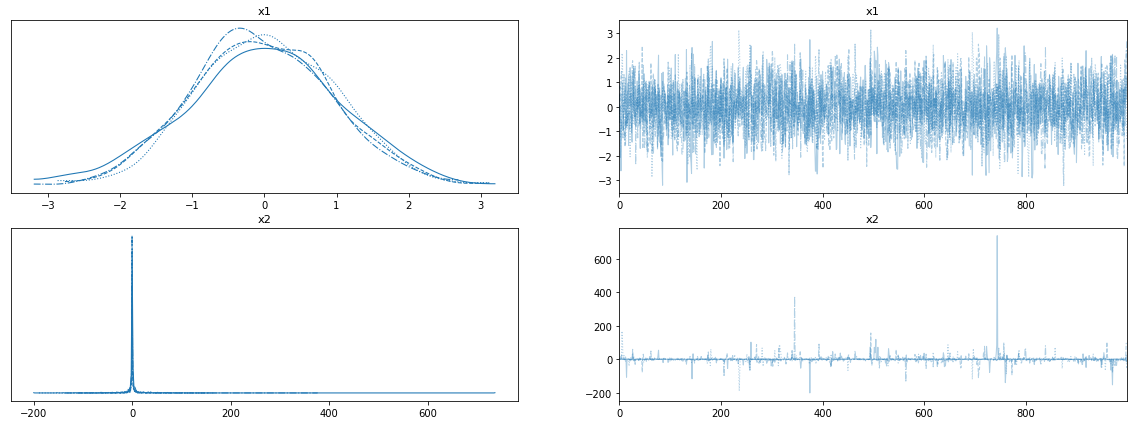

In [79]:
az.plot_trace(inf_samples, var_names=['x1', 'x2'], figsize=(20, 7))
az.plot_trace(inf_nuts, var_names=['x1', 'x2'], figsize=(20, 7))

array([[<AxesSubplot:ylabel='auto_shared_latent\n1'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='x1'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='x2'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='auto_shared_latent\n0', ylabel='x2_decentered'>,
        <AxesSubplot:xlabel='auto_shared_latent\n1'>,
        <AxesSubplot:xlabel='x1'>, <AxesSubplot:xlabel='x2'>]],
      dtype=object)

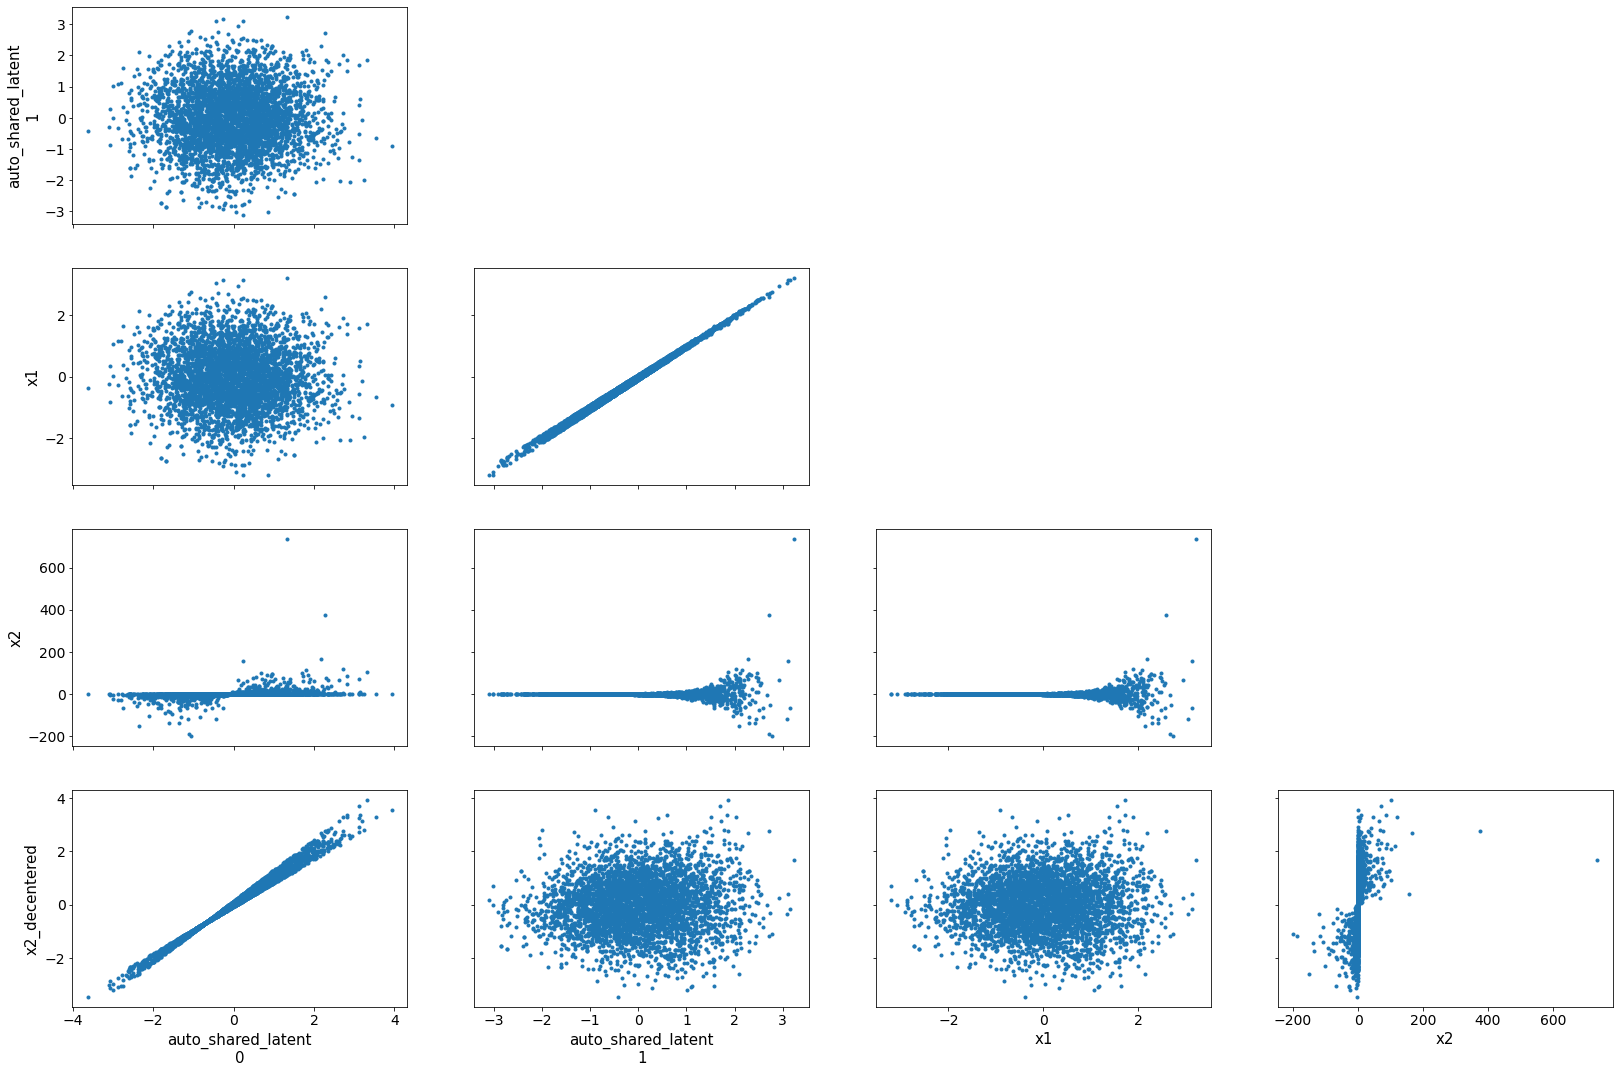

In [80]:
az.plot_pair(inf_nuts, divergences=True)

# Banana Density

In [6]:
def banana(x1, x2):
    """Banana density"""
    return stats.norm.logpdf(x1, 0.0, jnp.sqrt(8.0)) + stats.norm.logpdf(
        x2, 1 / 4 * x1**2, 1.0
    )
banana_fn = lambda x: banana(**x)

def banana_model():
    x1 = numpyro.sample('x1', dist.Normal(0., jnp.sqrt(8.)))
    numpyro.sample('x2', dist.Normal(1/4 * x1**2, 1.))

DeviceArray([1.217, 1.177, 1.233, 1.126], dtype=float32)

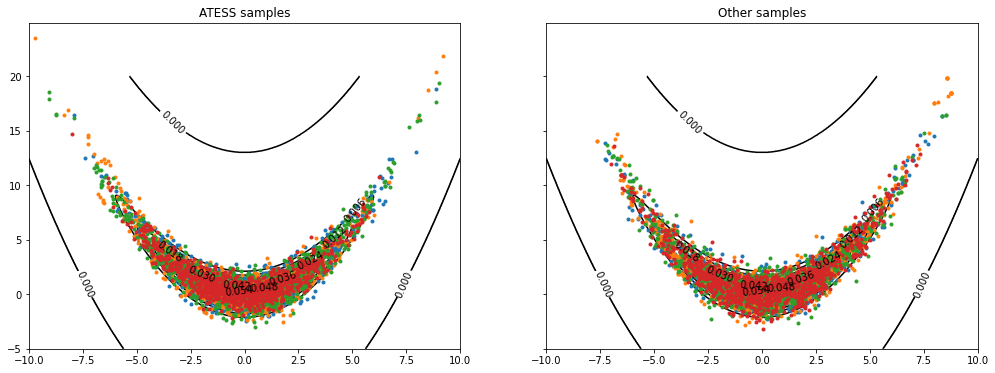

In [19]:
compare_plot_contour(banana_fn, samples, mcmc.get_samples(group_by_chain=True))
subiter

array([<AxesSubplot:title={'center':'x1'}, xlabel='Total number of draws', ylabel='ESS'>,
       <AxesSubplot:title={'center':'x2'}, xlabel='Total number of draws', ylabel='ESS'>],
      dtype=object)

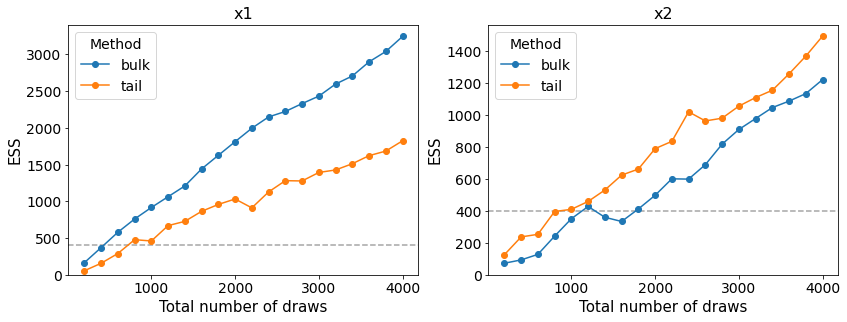

In [20]:
inf_samples = az.from_dict(samples)
inf_nuts = az.from_numpyro(mcmc)
az.plot_ess(inf_samples, kind="evolution")

array([<AxesSubplot:title={'center':'auto_shared_latent\n0'}, xlabel='Total number of draws', ylabel='ESS'>,
       <AxesSubplot:title={'center':'auto_shared_latent\n1'}, xlabel='Total number of draws', ylabel='ESS'>,
       <AxesSubplot:title={'center':'x1'}, xlabel='Total number of draws', ylabel='ESS'>,
       <AxesSubplot:title={'center':'x2'}, xlabel='Total number of draws', ylabel='ESS'>],
      dtype=object)

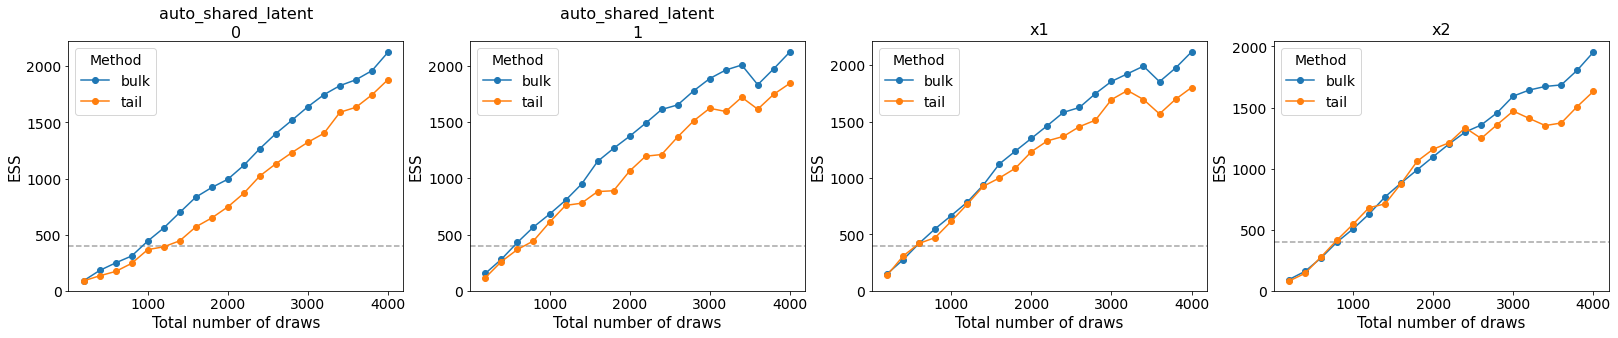

In [21]:
az.plot_ess(inf_nuts, kind="evolution")

array([[<AxesSubplot:title={'center':'x1'}>,
        <AxesSubplot:title={'center':'x1'}>],
       [<AxesSubplot:title={'center':'x2'}>,
        <AxesSubplot:title={'center':'x2'}>]], dtype=object)

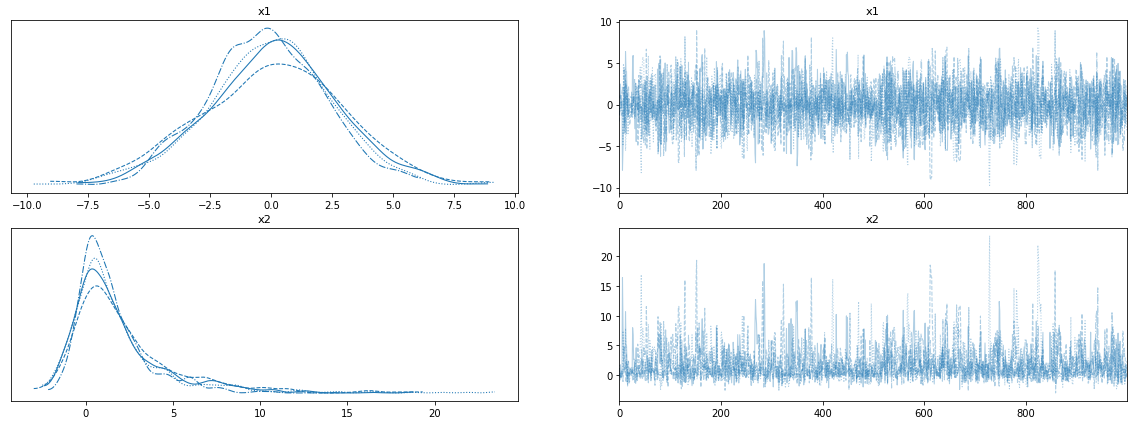

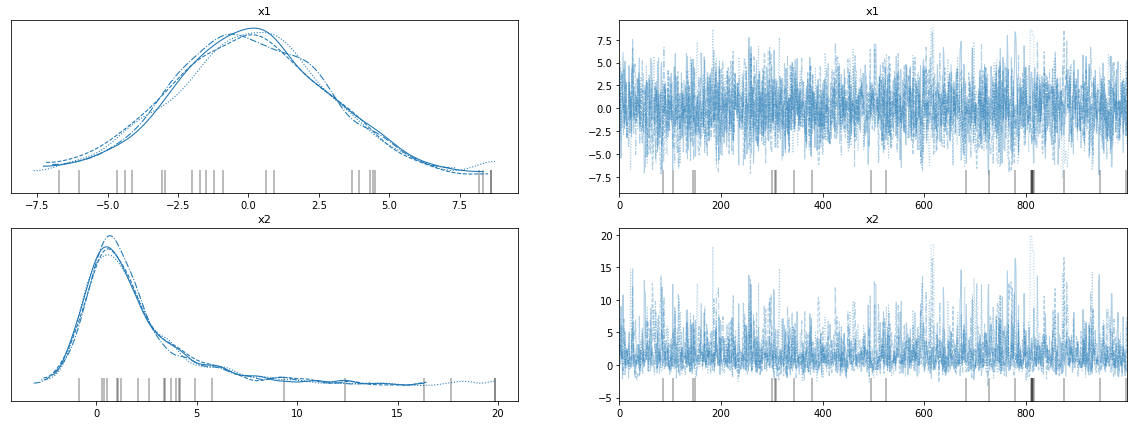

In [22]:
az.plot_trace(inf_samples, figsize=(20, 7))
az.plot_trace(inf_nuts, var_names=['x1', 'x2'], figsize=(20, 7))

array([[<AxesSubplot:ylabel='auto_shared_latent\n1'>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='x1'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='auto_shared_latent\n0', ylabel='x2'>,
        <AxesSubplot:xlabel='auto_shared_latent\n1'>,
        <AxesSubplot:xlabel='x1'>]], dtype=object)

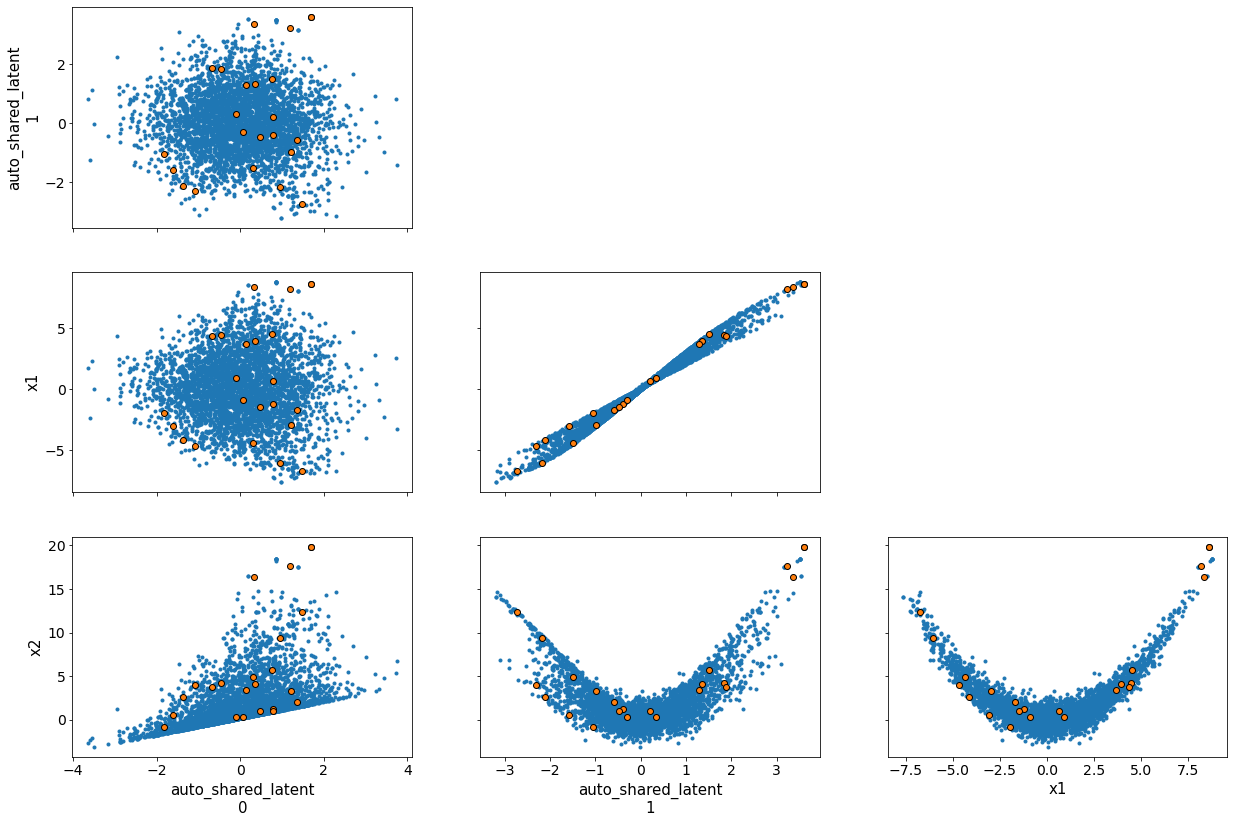

In [23]:
az.plot_pair(inf_nuts, divergences=True)

In [7]:
n = 2

# schedule = optax.polynomial_schedule(1e-2, 1e-4, 1, 9000, 1000)
# optim = optax.adam(schedule)#1e-2)
optim = optax.adam(1e-4)
# optim = optax.chain(
#     optax.clip(10.),
#     optax.adam(1e-3)
# )
non_lin = stax.Tanh
# non_lin = stax.Elu
n_hidden = [n] * 1
n_atoms = 1000
n_flow = 4

n_epochs = 10
batch_size = 1000
n_warm = n_epochs * batch_size

vi_iter = 1000
pre_iter = n_epochs * vi_iter
n_warm = vi_iter #too much warm up not good for nuts, it semms

n_iter = 1000
n_chain = 4

In [8]:
schedule = optax.polynomial_schedule(1e-2, 1e-4, 1, 9000, 1000)
optim = optax.adam(schedule)
non_lin = stax.Tanh

n_hidden = [n] * 1
n_atoms = 1000
n_flow = 2

vi_iter = 1000

ksam, ki1, ki2 = jrnd.split(jrnd.PRNGKey(0), 3)
init_xs = {'x1': jrnd.normal(ki1, shape=(n_chain,)), 'x2': jrnd.normal(ki2, shape=(n_chain,))}
samples = run_atess(
    ksam, banana_fn, init_xs,
    optim, n, n_flow, n_hidden, non_lin,
    n_atoms, vi_iter, n_epochs, batch_size,
    n_iter, n_chain,
)

TypeError: run_atess() missing 2 required positional arguments: 'tol' and 'maxiter'

In [17]:
atess, warm_fn = atransp_elliptical_slice(banana_fn, optim, n, n_flow, n_hidden, non_lin)
ksam, ki1, ki2 = jrnd.split(jrnd.PRNGKey(0), 3)

def one_chain(ksam, init_x):
    kinit, kwarm, ksam = jrnd.split(ksam, 3)
    state, param, err = atess.init(kinit, init_x, n_atoms, vi_iter)
    (state, param), error = warm_fn(kwarm, state, param, n_epochs, batch_size, vi_iter)
    states, info = inference_loop(ksam, state, atess.step, n_iter, param)
    return states.position, info.subiter.mean(), (err, param, error)

init_xs = {'x1': jrnd.normal(ki1, shape=(n_chain,)), 'x2': jrnd.normal(ki2, shape=(n_chain,))}
ksam = jrnd.split(ksam, n_chain)
samples, subiter, diagnose = jax.vmap(one_chain)(ksam, init_xs)
print_summary(samples)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        x1     -0.04      2.65      0.02     -4.74      4.01   3251.87      1.00
        x2      1.76      2.70      1.06     -1.69      5.44    757.62      1.01



In [16]:
ksam, ki1, ki2 = jrnd.split(jrnd.PRNGKey(0), 3)
init_xs = {'x1': jrnd.normal(ki1, shape=(n_chain,)), 'x2': jrnd.normal(ki2, shape=(n_chain,))}

samples = run_neutra(
    ksam, banana_fn, init_xs,
    optim, n, n_flow, n_hidden, non_lin,
    n_atoms, pre_iter, n_warm,
    n_iter, n_chain, nuts=True,
)

[4486.78672373 4484.04704474 4481.31783981 ... 3145.78003249 3145.74212487
 3145.70423569]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
        x1      0.37      1.32      0.25     -2.05      2.20     25.38      1.15
        x2     -0.57      1.65     -0.23     -3.04      2.31     16.82      1.27


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        x1      0.26      2.46      0.13     -4.09      3.89     45.85      1.10
        x2      1.53      2.39      1.02     -1.68      4.68     75.81      1.06



In [15]:
ksam, ki1, ki2 = jrnd.split(jrnd.PRNGKey(0), 3)
init_xs = {'x1': jrnd.normal(ki1, shape=(n_chain,)), 'x2': jrnd.normal(ki2, shape=(n_chain,))}

samples = run_neutra(
    ksam, banana_fn, init_xs,
    optim, n, n_flow, n_hidden, non_lin,
    n_atoms, pre_iter, n_warm,
    n_iter, n_chain, nuts=True,
)

[0.]
[1.]
[2.]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
        x1     -0.04      1.00     -0.08     -1.70      1.53   2904.47      1.00
        x2      0.02      0.97      0.03     -1.51      1.64   3667.80      1.00


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        x1      0.02      2.84      0.06     -4.51      4.66   2937.68      1.00
        x2      2.04      3.01      1.26     -1.65      5.89   2056.36      1.00



In [15]:
guide = AutoIAFNormal(banana_model, num_flows=n_flow, hidden_dims=n_hidden, nonlinearity=non_lin)
svi = SVI(banana_model, guide, optim, loss=Trace_ELBO(n_atoms))

ksam, ki1, ki2 = jrnd.split(jrnd.PRNGKey(0), 3)
params = svi.run(ksam, num_steps=pre_iter, progress_bar=False).params
neutra = NeuTraReparam(guide, params)
reparam_model = neutra.reparam(banana_model)

mcmc = MCMC(NUTS(reparam_model), num_warmup=n_warm, num_samples=n_iter, num_chains=n_chain, progress_bar=False)
init_xs = {'x1': jrnd.normal(ki1, shape=(n_chain,)), 'x2': jrnd.normal(ki2, shape=(n_chain,))}

ksam, kmcmc = jrnd.split(ksam)
mcmc.run(kmcmc, init_params=init_xs)
mcmc.print_summary(exclude_deterministic=False)

/tmp/ipykernel_78251/198310203.py:9: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(NUTS(reparam_model), num_warmup=n_warm, num_samples=n_iter, num_chains=n_chain, progress_bar=False)



                           mean       std    median      5.0%     95.0%     n_eff     r_hat
auto_shared_latent[0]      0.10      1.03      0.11     -1.65      1.74   2171.41      1.00
auto_shared_latent[1]      0.02      0.96      0.02     -1.47      1.68   2873.75      1.00
                   x1      0.08      2.76      0.06     -4.30      4.84   2826.39      1.00
                   x2      1.92      2.79      1.19     -1.94      5.73   1777.40      1.00

Number of divergences: 3


In [18]:
guide = AutoIAFNormal(banana_model, num_flows=n_flow, hidden_dims=n_hidden, nonlinearity=non_lin)
svi = SVI(banana_model, guide, optim, loss=Trace_ELBO(n_atoms))

ksam, ki1, ki2 = jrnd.split(jrnd.PRNGKey(0), 3)
params = svi.run(ksam, num_steps=pre_iter, progress_bar=False).params
neutra = NeuTraReparam(guide, params)
reparam_model = neutra.reparam(banana_model)

mcmc = MCMC(NUTS(reparam_model), num_warmup=n_warm, num_samples=n_iter, num_chains=n_chain, progress_bar=False)
init_xs = {'x1': jrnd.normal(ki1, shape=(n_chain,)), 'x2': jrnd.normal(ki2, shape=(n_chain,))}

ksam, kmcmc = jrnd.split(ksam)
mcmc.run(kmcmc, init_params=init_xs)
mcmc.print_summary(exclude_deterministic=False)

/tmp/ipykernel_833489/198310203.py:9: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(NUTS(reparam_model), num_warmup=n_warm, num_samples=n_iter, num_chains=n_chain, progress_bar=False)



                           mean       std    median      5.0%     95.0%     n_eff     r_hat
auto_shared_latent[0]      0.01      1.00      0.03     -1.66      1.59   2111.50      1.00
auto_shared_latent[1]      0.02      1.09     -0.00     -1.84      1.75   2051.96      1.00
                   x1      0.07      2.82      0.03     -4.58      4.73   2089.88      1.00
                   x2      2.01      2.96      1.21     -1.76      6.04   1432.81      1.00

Number of divergences: 23


In [13]:
# mcmc = MCMC(NUTS(banana_model), num_warmup=n_warm, num_samples=n_iter, num_chains=n_chain, progress_bar=False)
ksam, ki1, ki2 = jrnd.split(jrnd.PRNGKey(0), 3)
init_xs = {'x1': jrnd.normal(ki1, shape=(n_chain,)), 'x2': jrnd.normal(ki2, shape=(n_chain,))}

# mcmc.run(ksam, init_params=init_xs)
# mcmc.print_summary(exclude_deterministic=False)

samples = run_nuts(
    ksam, banana_fn, init_xs,
    n_warm, n_iter, n_chain,
)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        x1     -0.06      2.64      0.01     -4.52      4.14    226.13      1.02
        x2      1.74      2.30      1.27     -1.97      5.08    377.54      1.00



In [13]:
# mcmc = MCMC(NUTS(banana_model), num_warmup=n_warm, num_samples=n_iter, num_chains=n_chain, progress_bar=False)
ksam, ki1, ki2 = jrnd.split(jrnd.PRNGKey(0), 3)
init_xs = {'x1': jrnd.normal(ki1, shape=(n_chain,)), 'x2': jrnd.normal(ki2, shape=(n_chain,))}

# mcmc.run(ksam, init_params=init_xs)
# mcmc.print_summary(exclude_deterministic=False)

samples = run_nuts(
    ksam, banana_fn, init_xs,
    n_warm, n_iter, n_chain,
)

[0.]


/home/cabezasg/.local/lib/python3.8/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


[1.]
[2.]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
        x1      0.04      2.49      0.13     -3.91      4.21    408.79      1.01
        x2      1.53      2.08      1.19     -1.88      4.46    609.98      1.00



In [11]:
mcmc = MCMC(NUTS(banana_model), num_warmup=n_warm, num_samples=n_iter, num_chains=n_chain, progress_bar=False)
ksam, ki1, ki2 = jrnd.split(jrnd.PRNGKey(0), 3)
init_xs = {'x1': jrnd.normal(ki1, shape=(n_chain,)), 'x2': jrnd.normal(ki2, shape=(n_chain,))}

mcmc.run(ksam, init_params=init_xs)
mcmc.print_summary(exclude_deterministic=False)

/tmp/ipykernel_79808/2016790268.py:1: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(NUTS(banana_model), num_warmup=n_warm, num_samples=n_iter, num_chains=n_chain, progress_bar=False)



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        x1      0.32      2.72      0.37     -3.82      5.24    247.86      1.01
        x2      1.84      2.56      1.21     -1.80      5.77    229.28      1.02

Number of divergences: 36


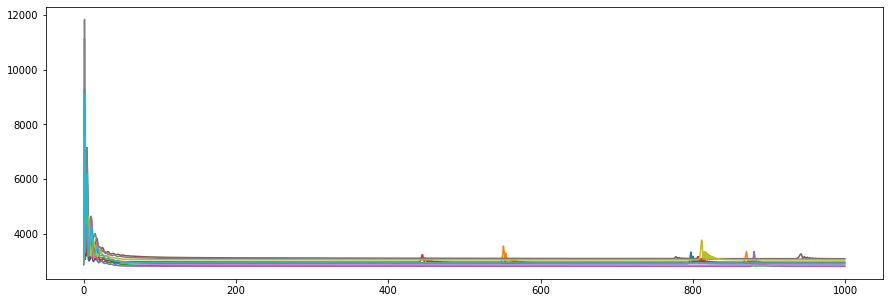

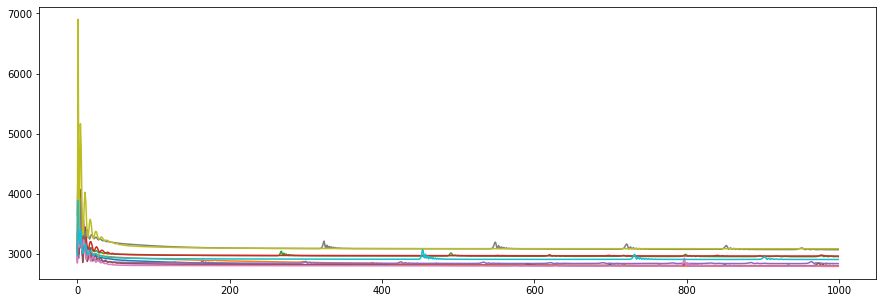

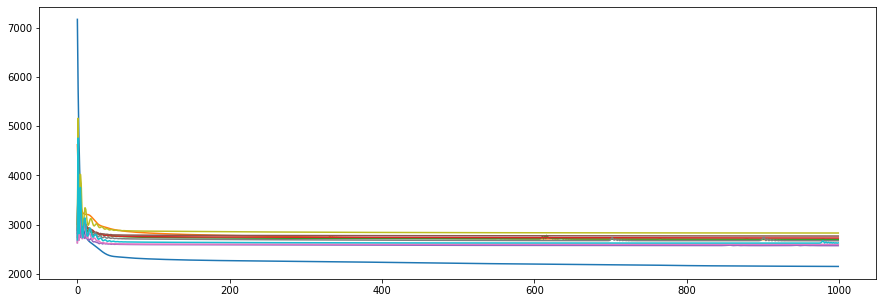

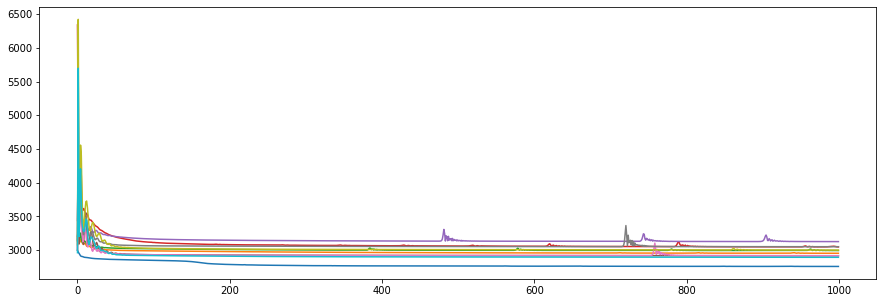

In [10]:
for i in range(n_chain):
    plt.figure(figsize=(15, 5))
    plt.plot(diagnose[2][i].T)
    plt.show()